In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/63.1 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [3]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 20.3 MB/s eta 0:00:00


In [4]:
# !pip install --upgrade torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.5.0+cu121.html

In [21]:
import numpy as np
import networkx as nx
import gym
from gym import spaces
import torch
import random
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from pyomo.environ import *
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv
from collections import deque
import torch as T
import torch.nn.functional as F
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [22]:
torch.__version__

'2.5.1'

In [44]:
num_microservices = 10
num_edge_servers =10

BLOCK_SIZE = 1 # For 1GB

microservice_graph = nx.DiGraph()
edge_network = nx.erdos_renyi_graph(num_edge_servers, 0.5, seed=123, directed=False)

for m in range(num_microservices):
    microservice_graph.add_node(m, requested_cpu=random.randint(500, 2000), requested_memory=random.randint(512, 1024), requested_disk=random.randint(2*BLOCK_SIZE, 4*BLOCK_SIZE))

# Add edges ensuring no cycles (DAG)
possible_edges = [(i, j) for i in range(num_microservices) for j in range(i + 1, num_microservices)]
for _ in range(num_microservices * 2):  # Add twice the number of nodes as edges
    if not possible_edges:
        break
    m1, m2 = random.choice(possible_edges)
    possible_edges.remove((m1, m2))
    bandwidth = random.randint(1, 10)
    microservice_graph.add_edge(m1, m2, bw_min=bandwidth)


for n in range(num_edge_servers):
    # Update node attr
    edge_network.add_node(n, available_cpu=random.randint(4000, 16000), available_memory=random.randint(4096, 2 * 4096), available_disk=random.randint(4*BLOCK_SIZE, 16*BLOCK_SIZE))

for n1, n2 in edge_network.edges():
    # n1, n2 = random.sample(range(num_edge_servers), 2)
    # Update edge attr
    bandwidth = random.randint(10, 100)
    edge_network.add_edge(n1, n2, bw=bandwidth, reverse_bw=1/bandwidth)

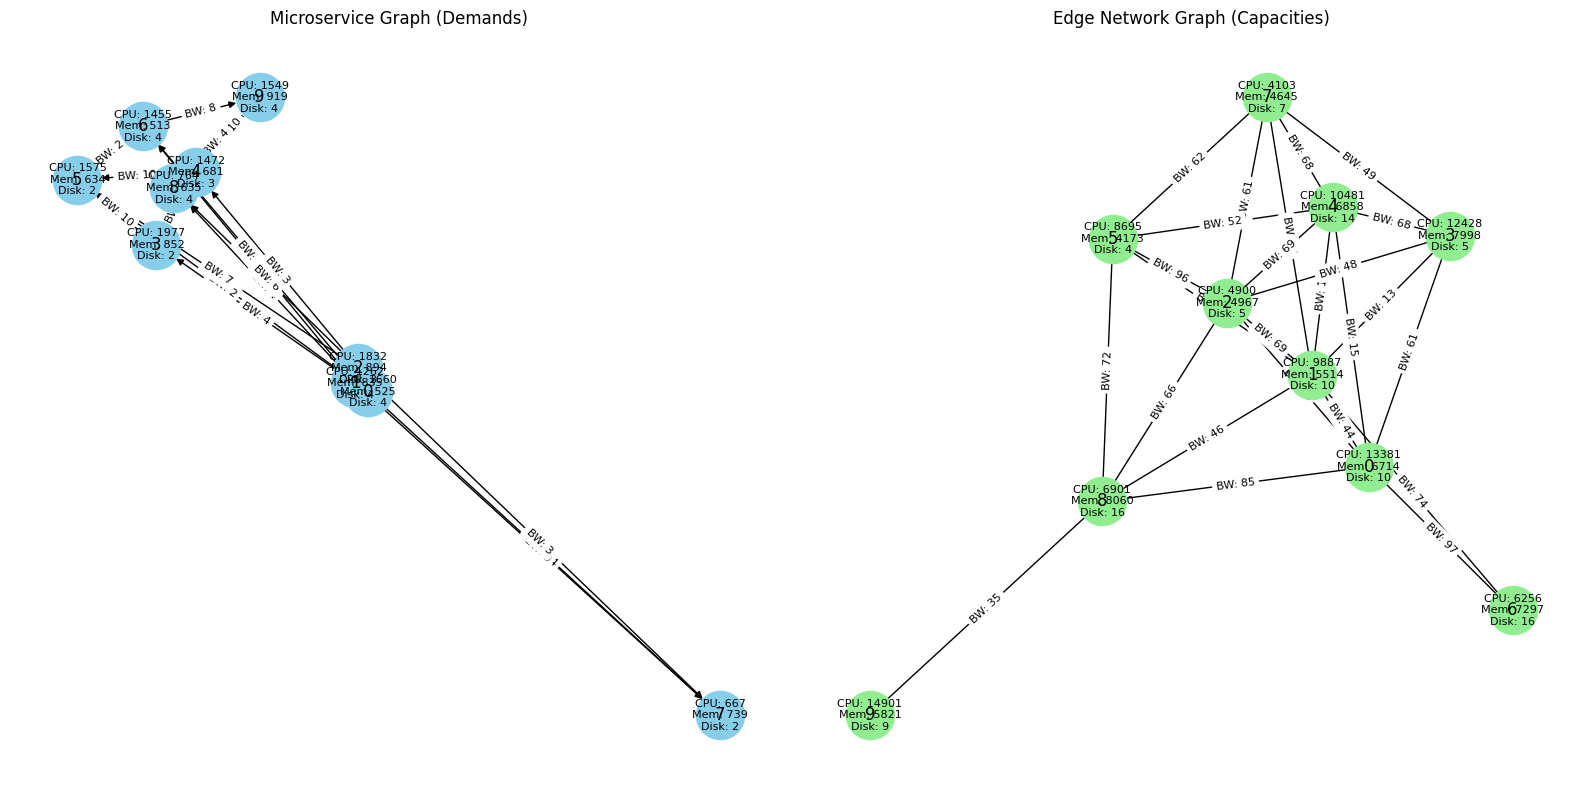

In [45]:
# Plotting Microservice Graph
plt.figure(figsize=(16, 8))

# Microservice Graph
plt.subplot(1, 2, 1)
pos_ms = nx.spring_layout(microservice_graph)
nx.draw(microservice_graph, pos_ms, with_labels=True, node_color='skyblue', node_size=1200)
labels_ms = {node: f"CPU: {microservice_graph.nodes[node]['requested_cpu']}\nMem: {microservice_graph.nodes[node]['requested_memory']}\nDisk: {microservice_graph.nodes[node]['requested_disk']}" for node in microservice_graph.nodes}
nx.draw_networkx_labels(microservice_graph, pos_ms, labels=labels_ms, font_size=8)

edge_labels_ms = {(u, v): f"BW: {data['bw_min']}" for u, v, data in microservice_graph.edges(data=True)}
nx.draw_networkx_edge_labels(microservice_graph, pos_ms, edge_labels=edge_labels_ms, font_size=8)
plt.title("Microservice Graph (Demands)")

# Edge Network Graph
plt.subplot(1, 2, 2)
pos_edge = nx.spring_layout(edge_network)
nx.draw(edge_network, pos_edge, with_labels=True, node_color='lightgreen', node_size=1200)
labels_edge = {node: f"CPU: {edge_network.nodes[node]['available_cpu']}\nMem: {edge_network.nodes[node]['available_memory']}\nDisk: {edge_network.nodes[node]['available_disk']}" for node in edge_network.nodes}
nx.draw_networkx_labels(edge_network, pos_edge, labels=labels_edge, font_size=8)

edge_labels_edge = {(u, v): f"BW: {data['bw']}" for u, v, data in edge_network.edges(data=True)}
nx.draw_networkx_edge_labels(edge_network, pos_edge, edge_labels=edge_labels_edge, font_size=8)
plt.title("Edge Network Graph (Capacities)")

plt.tight_layout()
plt.show()


In [46]:
import torch
import random
import networkx as nx
from torch_geometric.utils import from_networkx

class MicroservicePlacementEnv:
    def __init__(self, edge_network, num_microservices, max_disk_blocks=10):
        self.edge_network = edge_network
        self._edge_network = edge_network

        self.num_edge_servers = len(self.edge_network.nodes)
        self.num_microservices = num_microservices

        self.max_disk_blocks = max_disk_blocks
        self._is_done = False

    def reset(self):
        # Reinitialize the graphs
        self.edge_network = self._edge_network
        return self._get_observation()

    def step(self, action):
        """
        Take a step in the environment.
        Args:
            action: A tuple containing:
                - placement_decisions: A tensor of edge server indices where each microservice is placed.
                - disk_allocations: A tensor of disk blocks allocated per edge server for each microservice.

        Returns:
            observation: The updated state of the environment.
            reward: The reward for the current action.
            done: Whether the episode is finished.
            info: Additional information for debugging.
        """
        # placement_decisions, disk_allocations = action  # generated by the agent

        # Calculate the reward based on placement and disk allocation
        reward = self._calculate_reward(action)

        # Update the environment and generate the next observation
        observation = self._get_observation()
        done = self._is_done
        info = {}

        return observation, reward, done, info

    def _calculate_reward(self, x):
        # print(x)
        # print(y)
        # Calculate L_ms
        L_ms = 0
        for m1, m2 in self.microservice_graph.edges():
            for n1 in range(self.num_edge_servers):
                for n2 in range(self.num_edge_servers):
                    path_cost = (
                        nx.shortest_path_length(
                            self.edge_network, source=n1, target=n2, weight="reverse_bw"
                        )
                        if n1 != n2
                        else 0
                    )
                    L_ms += x[m1, n1] * x[m2, n2] * path_cost

        # Calculate L_vol
        L_vol = 0
        # for m in range(self.num_microservices):
        #     for n1 in range(self.num_edge_servers):
        #         for n2 in range(self.num_edge_servers):
        #             path_cost = (
        #                 nx.shortest_path_length(
        #                     self.edge_network, source=n1, target=n2, weight="reverse_bw"
        #                 )
        #                 if n1 != n2
        #                 else 0
        #             )
        #             L_vol += x[m, n1] * y[m, n2] * path_cost

        # Constraint violations
        constraint_violations = 0

        # Validate disk allocation constraints
        # for ms_id in range(self.num_microservices):
        #     if torch.sum(y[ms_id]) > self.max_disk_blocks:
        #         constraint_violations += 1

        # Placement constraint: Each microservice must be assigned to one edge server
        for m in range(self.num_microservices):
            if torch.sum(x[m, :]) != 1:
                self._is_done =  True
                constraint_violations += 1

        # Resource constraints per edge server
        for n in range(self.num_edge_servers):
            cpu_usage = sum(
                x[m, n] * self.microservice_graph.nodes[m]["requested_cpu"]
                for m in range(self.num_microservices)
            )
            memory_usage = sum(
                x[m, n] * self.microservice_graph.nodes[m]["requested_memory"]
                for m in range(self.num_microservices)
            )
            # disk_usage = sum(y[m, n] for m in range(self.num_microservices))

            if cpu_usage > self.edge_network.nodes[n]["available_cpu"]:
                self._is_done =  True
                constraint_violations += 1
            if memory_usage > self.edge_network.nodes[n]["available_memory"]:
                self._is_done =  True
                constraint_violations += 1
                
            # if disk_usage > self.edge_network.nodes[n]["available_disk"]:
            #     self._is_done =  True
            #     constraint_violations += 1
                

        # Disk demand constraint
        # for m in range(self.num_microservices):
        #     if not torch.isclose(
        #         torch.sum(y[m, :]), torch.tensor(self.microservice_graph.nodes[m]["requested_disk"])
        #     ):
        #         constraint_violations += 1

        # Penalty for constraint violations
        penalty = 100 * constraint_violations
        # Reduce resources based on the action
        if not self._is_done:
            for ms in range(self.num_microservices):
                cpu_demand, memory_demand = self.microservice_graph.nodes[ms]['requested_cpu'], microservice_graph.nodes[ms]['requested_memory']
                # print(x.argmax(dim=-1).cpu())
                ms_placed_on = x[ms].argmax(dim=-1).cpu().item()
                # data_placed_on = torch.nonzero(y[ms] > 0).squeeze(-1).cpu().detach()
                print(f"Updating ms placed on {ms_placed_on}")
                
                self.edge_network.nodes[ms_placed_on]['available_cpu'] -= cpu_demand
                self.edge_network.nodes[ms_placed_on]['available_memory'] -= memory_demand
                # for e in data_placed_on:
                #     print(f"Updating data placed on {e}")
                #     self.edge_network.nodes[e]['available_disk'] -= y[ms, e]
                
        # Reward is the negative of the cost and penalty
        reward = -(L_ms + L_vol + penalty)
        return reward

    def _get_observation(self):
        # Generate new microservice graph
        microservice_graph = nx.DiGraph()

        for m in range(self.num_microservices):
            microservice_graph.add_node(
                m,
                requested_cpu=random.randint(1000, 2000),
                requested_memory=random.randint(512, 1024),
                requested_disk=random.randint(2, 4),
            )

        # Add edges ensuring no cycles (DAG)
        possible_edges = [
            (i, j)
            for i in range(self.num_microservices)
            for j in range(i + 1, self.num_microservices)
        ]
        for _ in range(self.num_microservices * 2):
            if not possible_edges:
                break
            m1, m2 = random.choice(possible_edges)
            possible_edges.remove((m1, m2))
            bandwidth = random.randint(1, 10)
            microservice_graph.add_edge(m1, m2, bw_min=bandwidth)

        self.microservice_graph = microservice_graph

        ms_graph_data = self._ms_graph_to_torch(self.microservice_graph)
        edge_network_data = self._edge_network_to_torch(self.edge_network)


        return {
            "ms_graph_data": ms_graph_data,
            "edge_network_data": edge_network_data,
        }

    def _ms_graph_to_torch(self, G):
        data = from_networkx(G)
        data.x = torch.stack(
            [torch.tensor(data.requested_cpu), torch.tensor(data.requested_memory), torch.tensor(data.requested_disk)]
        ).T
        return data

    def _edge_network_to_torch(self, G):
        data = from_networkx(G)
        data.x = torch.stack(
            [
                torch.tensor(data.available_cpu),
                torch.tensor(data.available_memory),
                torch.tensor(data.available_disk),
            ]
        ).T
        return data

    def plot(self):
        microservice_graph = self.microservice_graph
        edge_network = self.edge_network
        
        plt.figure(figsize=(16, 8))
        
        # Microservice Graph
        plt.subplot(1, 2, 1)
        pos_ms = nx.spring_layout(microservice_graph)
        nx.draw(microservice_graph, pos_ms, with_labels=True, node_color='skyblue', node_size=1200)
        labels_ms = {node: f"CPU: {microservice_graph.nodes[node]['requested_cpu']}\nMem: {microservice_graph.nodes[node]['requested_memory']}\nDisk: {microservice_graph.nodes[node]['requested_disk']}" for node in microservice_graph.nodes}
        nx.draw_networkx_labels(microservice_graph, pos_ms, labels=labels_ms, font_size=8)
        
        edge_labels_ms = {(u, v): f"BW: {data['bw_min']}" for u, v, data in microservice_graph.edges(data=True)}
        nx.draw_networkx_edge_labels(microservice_graph, pos_ms, edge_labels=edge_labels_ms, font_size=8)
        plt.title("Microservice Graph (Demands)")
        
        # Edge Network Graph
        plt.subplot(1, 2, 2)
        pos_edge = nx.spring_layout(edge_network)
        nx.draw(edge_network, pos_edge, with_labels=True, node_color='lightgreen', node_size=1200)
        labels_edge = {node: f"CPU: {edge_network.nodes[node]['available_cpu']}\nMem: {edge_network.nodes[node]['available_memory']}\nDisk: {edge_network.nodes[node]['available_disk']}" for node in edge_network.nodes}
        nx.draw_networkx_labels(edge_network, pos_edge, labels=labels_edge, font_size=8)
        
        edge_labels_edge = {(u, v): f"BW: {data['bw']}" for u, v, data in edge_network.edges(data=True)}
        nx.draw_networkx_edge_labels(edge_network, pos_edge, edge_labels=edge_labels_edge, font_size=8)
        plt.title("Edge Network Graph (Capacities)")
        
        plt.tight_layout()
        plt.show()



In [47]:
# TODO: Implement for each graph type an encoder network

class GNNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNEncoder, self).__init__()
        self.output_dim = output_dim
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = x.to(torch.float)
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        # print(x.shape)
        return x

    def get_embedding_dim(self,):
        # TODO: Implement this
        return self.output_dim


In [48]:
class ReplayBuffer(): # ReplayBuffer class initializes an empty deque with a maximum length of buffer_size
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, s, a, r,s_next): # The add method is used to add the current state, the action taken, the reward received, the next state
        experience = (s, a, r,s_next)
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size): #he sample method is used to randomly sample a batch of experiences from the buffer of size batch_size
        minibatch = []
        if self.count < batch_size:
            minibatch = random.sample(self.buffer, self.count)
        else:
            minibatch = random.sample(self.buffer, batch_size)

        batch_s = [d[0] for d in minibatch]
        batch_a = [d[1] for d in minibatch]
        batch_r = [d[2] for d in minibatch]
        batch_s_next = [d[3] for d in minibatch]
        return batch_s, batch_a, batch_r,batch_s_next  # It returns five lists, one for each component of the experience tuple.

    def clear(self):  # the clear method clears the buffer
        self.buffer.clear()
        self.count = 0


In [49]:
class CriticNetwork(nn.Module):
    def __init__(self,
                 num_microservices,
                 num_edge_servers,
                 ms_gnn,
                 edge_network_gnn,
                 lr=5e-4,
                 input_dims=None,
                 fc1_dims=512,
                 fc2_dims=128,
                 fc3_dims=64,
                 name=None,
                 checkpoint_dir="/content/drive/MyDrive/models/"):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims  # State input dimensions
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.fc3_dims = fc3_dims
        self.num_microservices = num_microservices
        self.num_edge_servers = num_edge_servers
        self.ms_gnn = ms_gnn
        self.edge_network_gnn = edge_network_gnn
        self.name = name
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + "_ddpg")

        # Fully connected layers for state
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.fc3_dims)

        # Batch normalization
        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        self.bn3 = nn.LayerNorm(self.fc3_dims)

        # Fully connected layers for action
        # Action dimensions = placement + allocation
        action_dims = self.num_microservices * self.num_edge_servers  # Placement + allocation
        self.action_fc = nn.Linear(action_dims, self.fc3_dims)

        # Output layer for Q-value
        self.q = nn.Linear(self.fc3_dims, 1)

        # Parameter initialization
        self._init_weights()

        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=0.01)

        # Device
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def _init_weights(self):
        """Initialize weights for all layers."""
        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 1. / np.sqrt(self.fc3.weight.data.size()[0])
        self.fc3.weight.data.uniform_(-f3, f3)
        self.fc3.bias.data.uniform_(-f3, f3)

        f4 = 1. / np.sqrt(self.action_fc.weight.data.size()[0])
        self.action_fc.weight.data.uniform_(-f4, f4)
        self.action_fc.bias.data.uniform_(-f4, f4)

        f_out = 0.003
        self.q.weight.data.uniform_(-f_out, f_out)
        self.q.bias.data.uniform_(-f_out, f_out)

    def forward(self, states, actions):
        """
        Forward pass to compute Q-values for a batch of state-action pairs.
    
        Args:
            states (list of dict): A batch of state dictionaries. Each dictionary contains:
                - "ms_graph_data": Microservice graph data (torch_geometric.data.Data).
                - "edge_network_data": Edge network graph data (torch_geometric.data.Data).
            actions (torch.Tensor): A batch of action tensors 
                (batch_size, num_microservices * num_edge_servers * 2).
    
        Returns:
            torch.Tensor: Q-values of the state-action pairs (batch_size, 1).
        """
        batch_size = len(states)
    
        # Initialize lists to hold embeddings for the batch
        ms_embeddings = []
        edge_embeddings = []
    
        # Process each state in the batch
        for state in states:
            ms_graph = state["ms_graph_data"]
            edge_network = state["edge_network_data"]
    
            # Compute embeddings for the current state's microservice graph and edge network graph
            ms_embedding = self.ms_gnn(ms_graph.x, ms_graph.edge_index).mean(dim=0, keepdim=True)
            edge_embedding = self.edge_network_gnn(edge_network.x, edge_network.edge_index).mean(dim=0, keepdim=True)
    
            ms_embeddings.append(ms_embedding)
            edge_embeddings.append(edge_embedding)
    
        # Concatenate embeddings for the entire batch
        ms_embeddings = torch.cat(ms_embeddings, dim=0)  # Shape: (batch_size, embedding_dim)
        edge_embeddings = torch.cat(edge_embeddings, dim=0)  # Shape: (batch_size, embedding_dim)
    
        # Concatenate microservice and edge network embeddings for each state
        embeddings = torch.cat((ms_embeddings, edge_embeddings), dim=-1)  # Shape: (batch_size, input_dims)
    
        # Process state
        state_value = self.fc1(embeddings)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
    
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        state_value = F.relu(state_value)
    
        state_value = self.fc3(state_value)
        state_value = self.bn3(state_value)
        state_value = F.relu(state_value)
    
        flattened_actions = self.process_actions(actions)
        # print(flattened_actions.shape)
        action_value = self.action_fc(flattened_actions)
        action_value = F.relu(action_value)
    
        # Combine state and action values
        state_action_value = F.relu(state_value + action_value)
    
        # Output Q-value
        q_value = self.q(state_action_value)
    
        return q_value


    # Assuming actions is a list of tuples [(placement_matrix, allocation_matrix), ...]
    def process_actions(self, actions):
        flattened_actions = []
        if isinstance(actions, tuple):
            actions = [actions]
        for placement_matrix in actions:
            # Flatten each matrix
            flattened_placement = placement_matrix.view(placement_matrix.size(0), -1)  # (batch_size, num_microservices * num_edge_servers)
            # flattened_allocation = allocation_matrix.view(allocation_matrix.size(0), -1)  # (batch_size, num_microservices * num_edge_servers)
    
            # Concatenate the flattened matrices
            # combined_action = torch.cat((flattened_placement, flattened_allocation), dim=-1)  # (batch_size, action_dims)
            flattened_actions.append(flattened_placement)
    
        # Stack all processed actions into a single tensor
        flattened_actions = torch.cat(flattened_actions, dim=0)  # (batch_size, action_dims)
    
        return flattened_actions.reshape(-1, 100)
        # return action.view(action.size(0), -1)


    def save_checkpoint(self):
        print(" ... saving checkpoint ...")
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print(" ... loading checkpoint ...")
        self.load_state_dict(T.load(self.checkpoint_file))


In [50]:
class ActorNetwork(nn.Module):
    def __init__(self,
                 num_microservices,
                 num_edge_servers,
                 ms_gnn,
                 edge_network_gnn,
                 max_disk_blocks,
                 lr=5e-4,
                 input_dims=None,
                 fc1_dims=600,
                 fc2_dims=400,
                 fc3_dims=100,
                 name=None,
                 checkpoint_dir="/content/drive/MyDrive/models/tests"
        ):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.fc3_dims = fc3_dims
        self.num_microservices = num_microservices
        self.num_edge_servers = num_edge_servers
        self.ms_gnn = ms_gnn
        self.edge_network_gnn = edge_network_gnn
        self.max_disk_blocks = max_disk_blocks
        self.name = name
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + "_ddpg")
        
        
        self.ms_embedding_dim = ms_gnn.get_embedding_dim()
        self.edge_network_embedding_dim = ms_gnn.get_embedding_dim()
        self.hidden_dim = 100
        
        self.ms_encoder = nn.LSTM(self.ms_embedding_dim, self.hidden_dim, num_layers=1, batch_first=True)
        self.edge_network_encoder = nn.LSTM(self.edge_network_embedding_dim, self.hidden_dim, num_layers=1, batch_first=True)
        
        self.decoder = nn.LSTM(self.num_edge_servers, self.hidden_dim, num_layers=1, batch_first=True)
        
        # TODO: add attention
        

        #  # Output layers
        self.placement_output = nn.Linear(self.hidden_dim, self.num_edge_servers)
        # self.data_allocation_output = nn.Linear(self.fc3_dims, self.num_microservices * self.num_edge_servers)



        self.optimizer = optim.Adam(self.parameters(), lr=lr,
                                    weight_decay=0.01)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)



    def forward(self, states):
        batch_size = len(states)
        ms_embeddings = []
        edge_embeddings = []
    
        # Process each state in the batch
        for state in states:
            ms_graph = state["ms_graph_data"]
            edge_network = state["edge_network_data"]
    
            # Compute embeddings for the current state's microservice graph and edge network graph
            ms_embedding = self.ms_gnn(ms_graph.x, ms_graph.edge_index)
            edge_embedding = self.edge_network_gnn(edge_network.x, edge_network.edge_index)
    
            ms_embeddings.append(ms_embedding)
            edge_embeddings.append(edge_embedding)
    
        # Concatenate embeddings for the entire batch
        ms_embeddings = torch.stack(ms_embeddings)  # Shape: (batch_size, embedding_dim)
        edge_embeddings = torch.stack(edge_embeddings)  # Shape: (batch_size, embedding_dim)
        # print(ms_embeddings.shape)
        # TODO: Use the output to implement attention
        _, (ms_hidden_state_enc, ms_cell_state_enc) = self.ms_encoder(ms_embeddings)
        _, (edge_hidden_state_enc, edge_cell_state_enc) = self.edge_network_encoder(edge_embeddings)
        
        # hidden_combined = torch.cat((ms_hidden_state_enc, edge_hidden_state_enc), dim=-1)
        
        placement = -1 * torch.ones(batch_size, 1, self.num_edge_servers)
        outputs = torch.zeros(batch_size, self.num_microservices, num_edge_servers).to(self.device)
        hidden, cell = edge_hidden_state_enc, edge_cell_state_enc
        # print(hidden.shape)
        for t in range(self.num_microservices):
            output, (hidden, cell) = self.decoder(placement, (hidden, cell))
            placement_logits = self.placement_output(output)
            placement = F.softmax(placement_logits, dim=-1)
            # p = placement.squeeze()
            outputs[:, t] = placement.squeeze()
        # return outputs
        # print(outputs.shape)
        return outputs


    def save_checkpoint(self):
        print(" ... saving checkpoint ...")
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print(" ... loading checkpoint ...")
        self.load_state_dict(T.load(self.checkpoint_file))

In [51]:
# ## === TEST: Test the actor network ===
# gnn_input_dim = 3
# gnn_hidden_dim=128
# gnn_output_dim=64
# max_disk_blocks = 10
# env = MicroservicePlacementEnv(edge_network, num_microservices)
# ms_gnn = GNNEncoder(gnn_input_dim, gnn_hidden_dim, gnn_output_dim)
# edge_network_gnn = GNNEncoder(gnn_input_dim, gnn_hidden_dim, gnn_output_dim)
# actor = ActorNetwork(num_microservices, num_edge_servers, ms_gnn, edge_network_gnn, max_disk_blocks, name='actor')
# state1 = env.reset()
# state2 = env.reset()
# states = [state1, state2]



In [52]:
# actor(states)

In [53]:
class DDPGAgent():
    EPS_START = 0.9
    EPS_END = 0.05
    EPS_DECAY = 1000

    def __init__(self,
                 env,
                 gnn_input_dim=3,  # Features per node
                 gnn_hidden_dim=128,
                 gnn_output_dim=64,
                 gamma=0.95,
                 max_size=1000000,
                 fc1_dims=512,
                 fc2_dims=128,
                 batch_size=64,
                 max_disk_blocks=10,
                 tau=0.8,
        ):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.max_disk_blocks = max_disk_blocks
        self.env = env
        self.memory = ReplayBuffer(max_size)

        self.num_microservices = self.env.num_microservices
        self.num_edge_servers = self.env.num_edge_servers

        self.ms_gnn = GNNEncoder(gnn_input_dim, gnn_hidden_dim, gnn_output_dim)
        self.edge_network_gnn = GNNEncoder(gnn_input_dim, gnn_hidden_dim, gnn_output_dim)

        # Actor and Critic Networks
        self.actor = ActorNetwork(num_microservices, num_edge_servers, self.ms_gnn, self.edge_network_gnn, max_disk_blocks, fc1_dims, fc2_dims, name='actor')
        self.critic = CriticNetwork(num_microservices, num_edge_servers, self.ms_gnn, self.edge_network_gnn, fc1_dims, fc2_dims, name='critic')

        self.target_actor = ActorNetwork(num_microservices, num_edge_servers, self.ms_gnn, self.edge_network_gnn, max_disk_blocks, fc1_dims, fc2_dims, name='target_actor')
        self.target_critic = CriticNetwork(num_microservices, num_edge_servers, self.ms_gnn, self.edge_network_gnn, fc1_dims, fc2_dims, name='target_critic')

        self.update_network_parameters(tau=1)
        self.steps_done = 0

    def choose_action(self, observation):
        """
        Select an action using epsilon-greedy strategy.
        """
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            np.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            self.actor.eval()
            # state = torch.tensor([observation], dtype=torch.float).to(self.actor.device)
            placement = self.actor.forward(observation)
            self.actor.train()
            placement =  placement.cpu().detach()[0]
            # allocation = allocation.cpu().detach()[0]
            # action = (placement, allocation)
            placement = self.fix_action(placement)
            
            # print(f"Placement actor")
            return placement
        else:
            # Random action
            action = self.sample_random_action()
            action = self.fix_action(action)
            return action

    def sample_random_action(self):
        """
        Sample a random valid action using PyTorch.
        """
        # Random placement decisions
        placement = torch.distributions.Dirichlet(torch.ones(self.num_edge_servers)).sample((self.num_microservices,))
    
        # # Random disk allocation
        # allocation = torch.randint(
        #     0, self.max_disk_blocks, (self.num_microservices, self.num_edge_servers)
        # )
        
        return placement

    def fix_action(self, action):
        # original_placement, allocation = action
        placement = torch.zeros_like(action, dtype=torch.float32)
        placement[torch.arange(action.size(0)), torch.argmax(action, dim=1)] = 1.0
        return placement

    def remember(self, state, action, reward, state_):
        """
        Store a transition in memory.
        """
        self.memory.add(state, action, reward, state_)

    def learn(self):
        """
        Perform a single learning step.
        """
        if self.memory.size() < self.batch_size:
            return

        states, actions, rewards, states_ = self.memory.sample_batch(self.batch_size)
        # print(actions, rewards)
        # Convert to tensors
        # states = torch.tensor(states, dtype=torch.float).to(self.actor.device)
        # actions = torch.tensor(actions, dtype=torch.float).to(self.actor.device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(self.actor.device)
        # states_ = torch.tensor(states_, dtype=torch.float).to(self.actor.device)
        rewards = rewards.unsqueeze(1)

        # Target actions and Q-values
        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        # Compute target value
        target = rewards + self.gamma * critic_value_
        target = target.view(self.batch_size, 1)

        # Update critic
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(critic_value, target)
        critic_loss.backward()
        torch.nn.utils.clip_grad_value_(self.critic.parameters(), 100)
        self.critic.optimizer.step()

        # Update actor
        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        actor_loss.backward()
        torch.nn.utils.clip_grad_value_(self.actor.parameters(), 100)
        self.actor.optimizer.step()

        # Update target networks
        self.update_network_parameters()

        return critic_loss.item(), actor_loss.item()

    def update_network_parameters(self, tau=None):
        """
        Soft update of target network parameters.
        """
        if tau is None:
            tau = self.tau

        # Update critic
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        # Update actor
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def save(self):
        """
        Save network parameters.
        """
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load(self):
        """
        Load network parameters.
        """
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()


In [54]:
env = MicroservicePlacementEnv(edge_network, num_microservices)
agent = DDPGAgent(env)


In [55]:
num_episodes = 1000
num_steps = 100
batch_size = 256

In [56]:
rewards_history = []  # To track total rewards per episode
critic_losses = []  # To track critic loss per step
actor_losses = []  # To track actor loss per step

for episode in range(num_episodes):
    # Reset environment
    state = env.reset()
    ms_graph_data = state["ms_graph_data"]
    edge_network_data = state["edge_network_data"]

    total_reward = 0  # Track cumulative reward per episode

    for step in range(num_steps):
        # Select an action using the agent's policy
        with torch.no_grad():
            placement = agent.choose_action([{
                "ms_graph_data": ms_graph_data,
                "edge_network_data": edge_network_data,
            }])

        # action = (placement, allocation)

        # Perform action in the environment
        next_state, reward, done, info = env.step(placement)
        next_ms_graph_data = next_state["ms_graph_data"]
        next_edge_network_data = next_state["edge_network_data"]

        # Store the transition in replay buffer
        agent.remember({
            "ms_graph_data": ms_graph_data,
            "edge_network_data": edge_network_data,
        }, placement, reward, {
            "ms_graph_data": next_ms_graph_data,
            "edge_network_data": next_edge_network_data,
        })

        # Update state
        ms_graph_data = next_ms_graph_data
        edge_network_data = next_edge_network_data
        total_reward += reward

        # Learn from experience
        if agent.memory.size() > batch_size:
            critic_loss, actor_loss = agent.learn()
            critic_losses.append(critic_loss)
            actor_losses.append(actor_loss)

        # Check if episode is done
        if done:
            break

    # Track episode rewards
    rewards_history.append(total_reward)

    # Log progress
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward:.2f}")

    # Save models periodically
    # if (episode + 1) % 50 == 0:
    #     agent.save()



/tmp/ipykernel_402151/668860370.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(data.requested_cpu), torch.tensor(data.requested_memory), torch.tensor(data.requested_disk)]
/tmp/ipykernel_402151/668860370.py:193: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data.available_cpu),
/tmp/ipykernel_402151/668860370.py:194: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data.available_memory),
/tmp/ipykernel_402151/668860370.py:195: UserWarning: To copy construct from a tensor, it is recommended to u

Updating ms placed on 2
Updating ms placed on 0
Updating ms placed on 3
Updating ms placed on 7
Updating ms placed on 0
Updating ms placed on 0
Updating ms placed on 4
Updating ms placed on 7
Updating ms placed on 5
Updating ms placed on 4
Episode 1/1000, Total Reward: -200.65
Episode 2/1000, Total Reward: -0.54
Episode 3/1000, Total Reward: -0.33
Episode 4/1000, Total Reward: -100.53
Episode 5/1000, Total Reward: -100.37
Episode 6/1000, Total Reward: -100.47
Episode 7/1000, Total Reward: -100.45
Episode 8/1000, Total Reward: -100.34
Episode 9/1000, Total Reward: -100.71
Episode 10/1000, Total Reward: -0.55
Episode 11/1000, Total Reward: -100.62
Episode 12/1000, Total Reward: -100.61
Episode 13/1000, Total Reward: -100.34
Episode 14/1000, Total Reward: -100.50
Episode 15/1000, Total Reward: -100.60
Episode 16/1000, Total Reward: -0.54
Episode 17/1000, Total Reward: -100.53
Episode 18/1000, Total Reward: -100.56
Episode 19/1000, Total Reward: -100.53
Episode 20/1000, Total Reward: -100.

KeyboardInterrupt: 

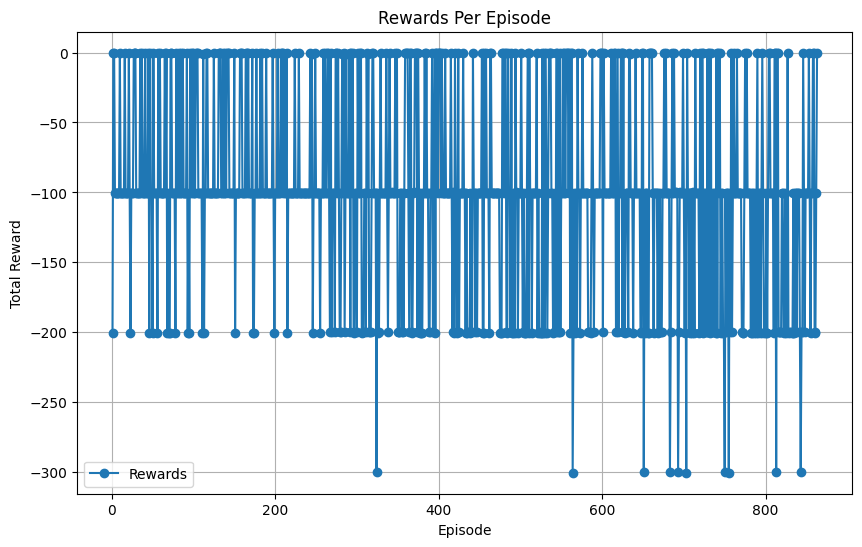

In [57]:
episodes = range(1, len(rewards_history) + 1)
steps = range(1, len(critic_losses) + 1)

# Plot rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards_history, label="Rewards", marker='o')
plt.title("Rewards Per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.legend()
plt.show()


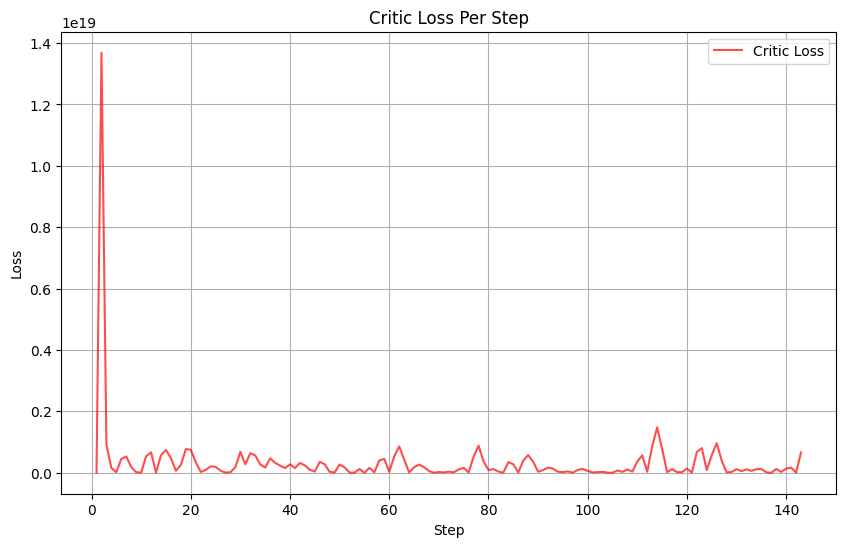

In [45]:

# Plot critic loss per step
plt.figure(figsize=(10, 6))
plt.plot(steps, critic_losses, label="Critic Loss", color="red", alpha=0.7)
plt.title("Critic Loss Per Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()



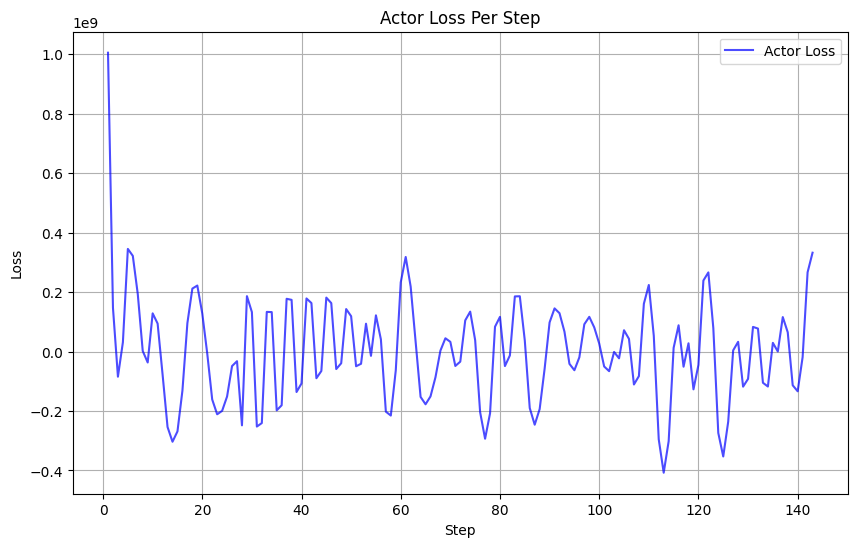

In [46]:
# Plot actor loss per step
plt.figure(figsize=(10, 6))
plt.plot(steps, actor_losses, label="Actor Loss", color="blue", alpha=0.7)
plt.title("Actor Loss Per Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()